In [2]:
include(joinpath("..","src","setup.jl"))
datadir = joinpath("..","data","count_lengths","run_2018-11-26")
using VegaLite
PlotAxes.set_backend!(:vegalite)

Activating environment at `~/Documents/work/projects/bistable/Project.toml`


:vegalite

In [57]:
params = load_params(joinpath(datadir,"params.jld2"))
params.pindex = 1:size(params,1)
settings = joinpath("..","src","settings.toml")
settings = TOML.parsefile(settings)
settings["stimulus"]["repeats"] = 96 #48

96

In [58]:
p = copy(params[select_params(params,f_c_a=5,f_c_m=5,Δf=6),:])
p.f_c_σ .= 0.2
p.s_c_a .= 5
p.s_c_m .= 5
p.s_c_σ .= 0.5
p.t_c_a .= 5
p.t_c_m .= 5
p.t_c_σ .= 0.5

1-element Array{Float64,1}:
 0.5

# Object model

In [251]:
p = copy(params[select_params(params,t_c_a=5,t_c_m=5,Δf=6),:])

1×36 DataFrame. Omitted printing of 29 columns
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f         │ t_W_m_c │ t_c_x   │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼───────────┼─────────┼─────────┤
│ 1   │ 5.6     │ 0.0     │ 5.0     │ 5.0     │ 500 Hz    │ 6.0     │ 3.0     │

In [252]:
p.t_c_a .= 15
p.t_c_m .= 5

1-element Array{Float64,1}:
 5.0

In [253]:
Random.seed!(111819)
result = bistable_model(p,settings,intermediate_results=true);

┌ Info: 0.22% of frames (n = 1) failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/Documents/work/projects/bistable/src/AuditoryBistabilityLE/src/nmf.jl:47


In [254]:
function cleanparam(x)
    x = replace(x, r"\(3.0 s, ([0-9\.]+)" => s"β = \1")
    x = replace(x, r"(?<=, )([0-9\.]+)(?=\))" => pat -> "κ = $(Int(parse(Float64,pat)/10))s/Δt")
    x = replace(x, ")" => "")
end

cleanparam (generic function with 1 method)

In [255]:
df, = PlotAxes.asplotable(result.sources.outweights[10s .. 20s],quantize=(100,10));
first(df,6)
df.params .= cleanparam.(df.params);

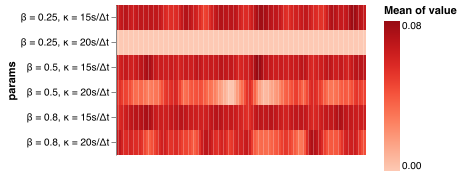

In [256]:
a = (df |> @vlplot(:rect, width=250, height=150,
      x={field=:time, typ="quantitative", bin={step=0.1}, axis=nothing}, #axis={values=[10,12.5,15,17.5,20]}},
      y={field=:params, typ="ordinal"},
      color={field=:value, aggregate="mean", typ="quantitative"},
      config={view={stroke="transparent"},
              scale={bandPaddingInner=0, bandPaddingOuter=0},
              range={heatmap={scheme="reds"}}}))

In [257]:
df,axes = PlotAxes.asplotable(result.primary_source[10s .. 20s],:time,:freq => logrange,quantize=(200,128))
first(df,6)

6×3 DataFrame
│ Row │ value      │ time    │ logfreq │
│     │ Float64    │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┤
│ 1   │ 7.47775e-6 │ 10.02   │ 6.02901 │
│ 2   │ 0.0100741  │ 10.08   │ 6.02901 │
│ 3   │ 0.025331   │ 10.13   │ 6.02901 │
│ 4   │ 0.00152425 │ 10.18   │ 6.02901 │
│ 5   │ 0.0        │ 10.23   │ 6.02901 │
│ 6   │ 0.0        │ 10.28   │ 6.02901 │

In [258]:
df.freq = exp.(df.log_freq);

ArgumentError: ArgumentError: column name :log_freq not found in the data frame; existing most similar names are: :logfreq

WARN Infinite extent for field "log_freq": [Infinity, -Infinity]
WARN Infinite extent for field "mean_value": [Infinity, -Infinity]


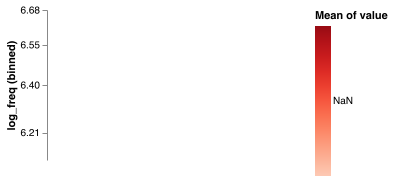

WARN Infinite extent for field "log_freq": [Infinity, -Infinity]
WARN Infinite extent for field "mean_value": [Infinity, -Infinity]


In [259]:
b = (df |> @vlplot(mark={:rect,clip=true}, width=250, height=150,
      x={field=:time, typ="quantitative", bin={step=axes[1].step}, axis=nothing}, #{values=[10,12.5,15,17.5,20]}},
      y={field=:log_freq, typ="quantitative", bin={step=axes[2].step}, 
      scale={domain=log.([450,800])}, axis={values=log.([500,600,700,800])}},
      color={field=:value, aggregate="mean", typ="quantitative"},
      config={view={stroke="transparent"},
              scale={bandPaddingInner=0, bandPaddingOuter=0},
              range={heatmap={scheme="reds"}}}))

In [260]:
len,val = result.percepts.counts

([1.5000000000000004, 1.9000000000000006, 0.8000000000000003, 1.6000000000000005, 4.100000000000001, 0.9000000000000004, 0.8000000000000003, 1.1000000000000003, 2.000000000000001, 2.8000000000000007  …  1.3000000000000005, 0.6000000000000002, 0.8000000000000003, 0.3000000000000001, 0.5000000000000002, 0.6000000000000002, 3.2000000000000015, 0.6000000000000002, 2.300000000000001, 0.3000000000000001], Bool[0, 1, 0, 1, 0, 1, 0, 1, 0, 1  …  0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [261]:
dfl = DataFrame(value=[val[1];val],time=[0;cumsum(len)]);
dfl[!,:lagtime] = lag(dfl.time,default=0);
c = (dfl |> @vlplot(mark={:rect,clip=true},width=250,height=15,
               x={field=:time,scale={domain=[10,20]}, axis={values=[10,12.5,15,17.5,20]}},
               x2=:lagtime,
               color={field=:value,typ="nominal",scale={scheme="set1"}}));

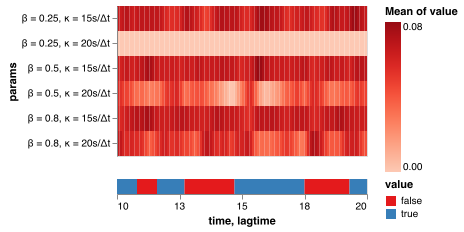

In [264]:
p = @vlplot(config={range={heatmap={scheme="reds"}},concat={spacing=5}}) + vcat(a,c)
p

In [265]:
save(joinpath(plotdir,"revision2_response_fig1a.pdf"),p)

# Central model

In [156]:
p = copy(params[select_params(params,s_c_a=15,s_c_m=44,Δf=6),:])

1×36 DataFrame. Omitted printing of 29 columns
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f         │ t_W_m_c │ t_c_x   │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼───────────┼─────────┼─────────┤
│ 1   │ 5.6     │ 0.0     │ 0.0     │ 0.0     │ 500 Hz    │ 6.0     │ 3.0     │

In [192]:
Random.seed!(111819)
result = bistable_model(p,settings,intermediate_results=true);

┌ Info: 1.74% of frames (n = 8) failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/Documents/work/projects/bistable/src/AuditoryBistabilityLE/src/nmf.jl:47


In [193]:
df, = PlotAxes.asplotable(result.cortical.outweights[10s .. 40s],quantize=(100,10));
first(df,6)

6×3 DataFrame
│ Row │ value        │ time    │ scale   │
│     │ Float64      │ Float64 │ Float64 │
├─────┼──────────────┼─────────┼─────────┤
│ 1   │ -2.29785e-24 │ 10.15   │ 0.5     │
│ 2   │ 2.15329e-24  │ 10.46   │ 0.5     │
│ 3   │ -7.80706e-25 │ 10.76   │ 0.5     │
│ 4   │ 1.66711e-25  │ 11.06   │ 0.5     │
│ 5   │ -1.64523e-26 │ 11.36   │ 0.5     │
│ 6   │ -3.72632e-27 │ 11.66   │ 0.5     │

In [194]:
a = (df |> @vlplot(:rect, width=250, height=150,
      x={field=:time, typ="quantitative", bin={step=0.3}, axis=nothing}, #axis={values=[10,12.5,15,17.5,20]}},
      y={field=:scale, typ="ordinal"},
      color={field=:value, aggregate="mean", typ="quantitative"},
      config={view={stroke="transparent"},
              scale={bandPaddingInner=0, bandPaddingOuter=0},
              range={heatmap={scheme="reds"}}}));

In [195]:
df,axes = PlotAxes.asplotable(result.primary_source[10s .. 40s],:time,:freq => logrange,quantize=(600,128))
first(df,6)

6×3 DataFrame
│ Row │ value      │ time    │ logfreq │
│     │ Float64    │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┤
│ 1   │ 5.64e-6    │ 10.02   │ 6.02901 │
│ 2   │ 0.0166783  │ 10.08   │ 6.02901 │
│ 3   │ 0.0284418  │ 10.13   │ 6.02901 │
│ 4   │ 0.00143007 │ 10.18   │ 6.02901 │
│ 5   │ 0.0        │ 10.23   │ 6.02901 │
│ 6   │ 0.0        │ 10.28   │ 6.02901 │

In [196]:
len,val = result.percepts.counts

([1.5000000000000004, 1.1000000000000003, 1.3000000000000005, 1.1000000000000005, 0.9000000000000004, 9.000000000000004, 0.7000000000000002, 0.5000000000000002, 4.100000000000001, 6.700000000000002, 4.000000000000002, 5.000000000000002, 1.4000000000000004, 2.000000000000001, 2.5000000000000013, 3.5000000000000013], Bool[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [197]:
dfl = DataFrame(value=[val[1];val],time=[0;cumsum(len)]);
dfl[!,:lagtime] = lag(dfl.time,default=0);
c = (dfl |> @vlplot(mark={:rect,clip=true},width=250,height=15,
               x={field=:time,scale={domain=[10,40]}, axis={values=[10,20,30,40]}},
               x2=:lagtime,
               color={field=:value,typ="nominal",scale={scheme="set1"}}));

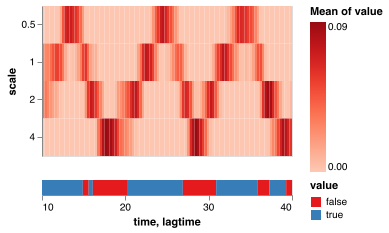

In [205]:
p = @vlplot(config={range={heatmap={scheme="reds"}},concat={spacing=6}}) + vcat(a,c)
p

In [206]:
save(joinpath(plotdir,"revision2_response_fig1b.pdf"),p)

# Peripheral model

In [222]:
p = copy(params[select_params(params,f_c_a=5,f_c_m=44,Δf=6),:])

1×36 DataFrame. Omitted printing of 29 columns
│ Row │ f_W_m_σ │ f_c_m   │ t_c_a   │ t_c_m   │ f         │ t_W_m_c │ t_c_x   │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Quantity… │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼───────────┼─────────┼─────────┤
│ 1   │ 5.6     │ 44.0    │ 0.0     │ 0.0     │ 500 Hz    │ 6.0     │ 3.0     │

In [208]:
#p.f_c_m .= 200

1-element Array{Float64,1}:
 200.0

In [242]:
Random.seed!(111819)
result = bistable_model(p,settings,intermediate_results=true);

In [243]:
df, = PlotAxes.asplotable(result.spect.result[10s .. 20s],:time,:freq => logrange, quantize=(200,128))
first(df,6)

6×3 DataFrame
│ Row │ value        │ time    │ logfreq │
│     │ Float64      │ Float64 │ Float64 │
├─────┼──────────────┼─────────┼─────────┤
│ 1   │ -3.23987e-25 │ 10.02   │ 4.52719 │
│ 2   │ -8.42532e-26 │ 10.08   │ 4.52719 │
│ 3   │ 5.44268e-26  │ 10.13   │ 4.52719 │
│ 4   │ 1.2864e-25   │ 10.18   │ 4.52719 │
│ 5   │ 1.55087e-25  │ 10.23   │ 4.52719 │
│ 6   │ 1.42805e-25  │ 10.28   │ 4.52719 │

In [244]:
a = (df |> @vlplot(mark={:rect,clip=true}, width=250, height=150,
      x={field=:time, typ="quantitative", bin={step=axes[1].step}, axis=nothing}, #{values=[10,12.5,15,17.5,20]}},
      y={field=:logfreq, typ="quantitative", bin={step=axes[2].step}, 
      scale={domain=log.([450,800])}, axis={values=log.([500,600,700,800])}},
      color={field=:value, aggregate="mean", typ="quantitative"},
      config={view={stroke="transparent"},
              scale={bandPaddingInner=0, bandPaddingOuter=0},
              range={heatmap={scheme="reds"}}}));

In [245]:
len,val = result.percepts.counts

([5.600000000000001, 2.900000000000001, 1.7000000000000006, 0.40000000000000013, 2.700000000000001, 2.4000000000000012, 2.400000000000001, 3.7000000000000015, 1.6000000000000005, 1.1000000000000003  …  1.1000000000000003, 0.9000000000000004, 1.9000000000000006, 1.8000000000000007, 4.500000000000002, 0.40000000000000013, 0.5000000000000002, 0.7000000000000003, 2.400000000000001, 0.40000000000000013], Bool[0, 1, 0, 1, 0, 1, 0, 1, 0, 1  …  0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [246]:
dfl = DataFrame(value=[val[1];val],time=[0;cumsum(len)]);
dfl[!,:lagtime] = lag(dfl.time,default=0);
c = (dfl |> @vlplot(mark={:rect,clip=true},width=250,height=15,
               x={field=:time,scale={domain=[10,20]}, axis={values=[10,12.5,15,17.5,20]}},
               x2=:lagtime,
               color={field=:value,typ="nominal",scale={scheme="set1"}}));

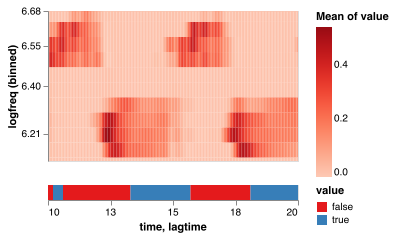

In [249]:
p = @vlplot(config={range={heatmap={scheme="reds"}},concat={spacing=5}}) + vcat(a,c)
p

In [250]:
save(joinpath(plotdir,"revision2_response_fig1c.pdf"),p)